# import

In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Generate Data, Algorithm

In [79]:
region = 6
PCF = 470 #553
mother_directory = f"/content/drive/MyDrive/MS thesis/[optimize] Training, Testing/RG{region}/"

existing_region_rhus = pd.read_csv(f"/content/drive/MyDrive/MS thesis/preliminary site selection/RG{region}/rg{region}_clusters.csv")
raw_rg1_clustered = pd.read_csv(mother_directory + "PCF_data.csv")
# use pcf data nalang para you dont get nans for sure?

neighbors_df = pd.read_csv(mother_directory + 'neighbours.csv')
candidate_sites = pd.read_csv(mother_directory + "candidate_sites.csv")
results = pd.read_csv(mother_directory + "results.csv")

# raw_rg1_clustered = raw_rg1_clustered.drop(columns=['Unnamed: 0'])
neighbors_df.rename(columns={'fid': 'ID'}, inplace=True)
# raw_rg1_clustered = raw_rg1_clustered.drop(columns=['HCFAI.1'])
print(raw_rg1_clustered.columns)
print(existing_region_rhus.columns)
# raw_rg1_clustered = raw_rg1_clustered.drop(columns=['total_population'])
# existing_region_rhus = existing_region_rhus.drop(columns=['Unnamed: 0'])
print('===')
print(raw_rg1_clustered.columns)
print(existing_region_rhus.columns)


Index(['flood_probability_value', 'rain intensity_value', 'drought_value',
       'Distance_to_Nearest_RHU_km', 'popden_chi', 'popden_eld', 'popden_all',
       'popden_wom', 'popden_w_1', 'popden_you', 'HCFAI', 'total_population',
       'RHU_Presence', 'ID', 'buildability_landcov', 'Road_Presence',
       'POI_Presence', 'Nearest_RHU', 'Cluster'],
      dtype='object')
Index(['Unnamed: 0', 'ID', 'barangay_name', 'city_name', 'province_name',
       'flood_probability_value', 'rain intensity_value', 'drought_value',
       'buildability_landcov', 'RHU_Presence', 'Road_Presence', 'POI_Presence',
       'Nearest_RHU', 'Distance_to_Nearest_RHU_km', 'popden_chi', 'popden_eld',
       'popden_all', 'popden_wom', 'popden_w_1', 'popden_you', 'HCFAI',
       'Cluster'],
      dtype='object')
===
Index(['flood_probability_value', 'rain intensity_value', 'drought_value',
       'Distance_to_Nearest_RHU_km', 'popden_chi', 'popden_eld', 'popden_all',
       'popden_wom', 'popden_w_1', 'popden_you

In [85]:
def HCI_calc(total_ai, total_gi, total_hi, total_ji, total_ki, total_mi, distance, road_bi, POI_ci, landCov_di, hazard1_ei, hazard2_ei, hazard3_ei, rhus_fi):
    total_vulnerable = total_gi + total_hi + total_ji + total_ki + total_mi
    total_pop = total_ai
    population_to_be_served = total_vulnerable + np.maximum(0, total_pop - total_vulnerable)
    y = np.where(population_to_be_served == 0, 0, 20000 / ((population_to_be_served) * (distance + rhus_fi)))
    mc = np.tanh(y)
    w_bi = 0.3  # roads
    w_ci = 0.2  # POIs
    w_di = 0.5  # land cov
    b = (POI_ci * w_ci) + (road_bi * w_bi) + (landCov_di * w_di)
    rain_intensity_normalized = (hazard1_ei - hazard1_ei.min()) / (hazard1_ei.max() - hazard1_ei.min())
    flood_probability_normalized = (hazard2_ei - hazard2_ei.min()) / (hazard2_ei.max() - hazard2_ei.min())
    drought_mean_normalized = (hazard3_ei - hazard3_ei.min()) / (hazard3_ei.max() - hazard3_ei.min())
    w_rain = 0.4
    w_flood = 0.3
    w_drought = 0.3
    c = (w_rain * rain_intensity_normalized) + (w_flood * flood_probability_normalized) + (w_drought * drought_mean_normalized)
    f = b - c
    f = np.tanh(f)
    hci = mc * f
    hcfai = (1 + np.tanh(hci / 2)) / 2  # Sigmoid function

    return hcfai

def overallHCFAI(region_df):
    if 'HCFAI' in region_df.columns:
        HCFAI_overall = region_df['HCFAI'].sum()
    elif 'new HCFAI' in region_df.columns:
        HCFAI_overall = region_df['new HCFAI'].sum()
    return HCFAI_overall

def selectTopSites(candidate_sites, region_df, selected_sites, n):
    if len(selected_sites) < n:  # if optimal and existing RHUs list is incomplete
        while len(selected_sites) < n:
            new_site = candidate_sites.iloc[:1].copy()
            selected_sites = pd.concat([selected_sites, new_site], ignore_index=True)
            candidate_sites = candidate_sites.drop(candidate_sites.index[0]).reset_index(drop=True)

    # region_df = region_df.drop('total_population', axis=1)

    columns_to_merge = ['ID',
                        'popden_chi', 'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1',
                        'popden_all', 'flood_probability_value', 'rain intensity_value',
                        'drought_value', 'buildability_landcov', 'RHU_Presence',
                        'Road_Presence', 'POI_Presence', 'Nearest_RHU',
                        'Distance_to_Nearest_RHU_km']

    merged_sites = candidate_sites.merge(region_df[columns_to_merge], on='ID', how='left')
    merged_sites['HCFAI'] = HCI_calc(merged_sites['popden_all'],
                                     merged_sites['popden_chi'],
                                     merged_sites['popden_eld'],
                                     merged_sites['popden_wom'],
                                     merged_sites['popden_you'],
                                     merged_sites['popden_w_1'],
                                     merged_sites['Distance_to_Nearest_RHU_km'],
                                     merged_sites['Road_Presence'],
                                     merged_sites['POI_Presence'],
                                     merged_sites['buildability_landcov'],
                                     merged_sites['rain intensity_value'],
                                     merged_sites['flood_probability_value'],
                                     merged_sites['drought_value'],
                                     merged_sites['RHU_Presence'],
                                     )

    missing_cols = [col for col in region_df.columns if col != 'ID']
    for col in missing_cols:
        if 'ID' not in region_df.columns:
            region_df.set_index('ID', inplace=True)
        merged_sites[col] = merged_sites[col].fillna(region_df[col])

    top_sites = merged_sites.sort_values(by='HCFAI', ascending=False).head(n)
    return top_sites

def removeAdjacentSites(region_df, candidate_sites, selected_sites, neighbors_df, n):
    idx_with_RHU = region_df[region_df['RHU_Presence'] == 1]
    adjacent_sites = set()
    with_RHU_indices = selected_sites['ID'].tolist()
    for site_id in selected_sites['ID']:
        if site_id in neighbors_df['ID'].values:
            neighbors = neighbors_df.loc[neighbors_df['ID'] == site_id, 'neighbours'].iloc[0]
            adjacent_sites.update(neighbors.split(','))
    adjacent_sites.update(idx_with_RHU['ID'])
    adjacent_sites.update(selected_sites['ID'])
    adjacent_sites = [int(site) for site in adjacent_sites]
    candidate_sites = candidate_sites[~candidate_sites['ID'].isin(adjacent_sites)].reset_index(drop=True)

    # print(f"{len(candidate_sites)} Candidate sites left")
    # print(f"This is what we'll put on QGIS: {selected_sites['ID'].tolist()}")

    if len(candidate_sites) > n:
      for i in with_RHU_indices:
          # print(f"Site {i} has the following sites to choose from: {candidate_sites['ID'].tolist()}")
          if i in adjacent_sites:
              # print(f"Site {i} was highkey sus for not saying they have neighbors ...")
              with_RHU_indices.remove(i)
              selected_sites = selected_sites.drop(selected_sites[selected_sites['ID'] == i].index).reset_index(drop=True)
    elif len(candidate_sites) <= n:
      return candidate_sites, selected_sites, idx_with_RHU

    selected_sites['HCFAI'] = HCI_calc(selected_sites['popden_all'], selected_sites['popden_chi'],
                                       selected_sites['popden_eld'], selected_sites['popden_wom'],
                                       selected_sites['popden_you'], selected_sites['popden_w_1'],
                                       selected_sites['Distance_to_Nearest_RHU_km'],
                                       selected_sites['Road_Presence'], selected_sites['POI_Presence'],
                                       selected_sites['buildability_landcov'], selected_sites['rain intensity_value'],
                                       selected_sites['flood_probability_value'], selected_sites['drought_value'],
                                       selected_sites['RHU_Presence'])
    return candidate_sites, selected_sites, idx_with_RHU

def optimize(region_df, candidate_sites, neighbors_df, num_facilities):
    original_HCFAI = overallHCFAI(region_df)
    # print("Original HCFAI:", original_HCFAI)
    # print(region_df.columns)
    region_df = region_df.drop(['total_population'], axis=1)

    selected_sites = pd.DataFrame(columns=region_df.columns)
    top_sites = selectTopSites(candidate_sites, region_df, selected_sites, num_facilities - len(selected_sites))

    while len(selected_sites) < num_facilities:
        # candidate_sites, top_sites, idx_with_RHU = removeAdjacentSites(region_df, candidate_sites, top_sites, neighbors_df, num_facilities)
        if len(candidate_sites) <= num_facilities:
          top_sites = candidate_sites
        elif len(candidate_sites) > num_facilities:
          top_sites = selectTopSites(candidate_sites, region_df, selected_sites, num_facilities - len(selected_sites))
          selected_sites = top_sites

        candidate_sites, top_sites, idx_with_RHU = removeAdjacentSites(region_df, candidate_sites, top_sites, neighbors_df, num_facilities)
        selected_sites = pd.concat([selected_sites, top_sites]).reset_index(drop=True)
        remaining_sites = region_df[~region_df['ID'].isin(selected_sites['ID'])] # HCFAI did not change

        selected_sites['RHU_Presence'] = 1
        remaining_HCFAI = overallHCFAI(remaining_sites)
        selected_sites_HCFAI = overallHCFAI(selected_sites)
        updated_HCFAI = remaining_HCFAI + selected_sites_HCFAI

         # Assuming df is your DataFrame
        vp =  selected_sites['popden_chi'] + selected_sites['popden_eld'] + selected_sites['popden_wom'] + selected_sites['popden_you'] + selected_sites['popden_w_1'] + selected_sites['popden_you']
        gen = selected_sites['popden_all'] - vp
        all = vp + gen
        selected_sites['total_population'] = all
        print(selected_sites['total_population']) # trying to see how much more of the population gets healthcare access

        # places_with_rhu = region_df.copy()
        # x = region_df[region_df['RHU_Presence' == 1]]
        # print(x['total_population'])

        # print("Updated HCFAI:", updated_HCFAI)
        # print(f"{len(selected_sites)} selected sites")

        if len(selected_sites) == num_facilities:
            print("Accept!!!!!!!!!!!!!!")
            return selected_sites, idx_with_RHU, original_HCFAI, updated_HCFAI

        elif len(candidate_sites) <= num_facilities:
            return selected_sites, idx_with_RHU, original_HCFAI, updated_HCFAI

        else:
            print("Reject!!!!!!!!!!!!!!")
            print("Selected sites:", len(selected_sites))
            top_sites = selectTopSites(candidate_sites, region_df, selected_sites, num_facilities - len(selected_sites))

    return selected_sites, idx_with_RHU, original_HCFAI, updated_HCFAI

# LGA - PCF formula

In [ ]:
print(f"Candidate sites: {len(candidate_sites)}")
print(f"Existing RHU sites: {existing_region_rhus[existing_region_rhus['RHU_Presence'] == 1]['ID'].tolist()}")
print(list(candidate_sites['ID']))
print(list(existing_region_rhus[existing_region_rhus['RHU_Presence'] == 1]['ID']))

Candidate sites: 3313
Existing RHU sites: [3191699, 3195843, 3199993, 3222135, 3226281, 3244251, 3258091, 3258144, 3271970, 3276099, 3281579, 3282963, 3283013, 3334079, 3340987]
[3141937, 3143315, 3143317, 3143318, 3143319, 3143320, 3143321, 3144697, 3144700, 3144703, 3144705, 3146079, 3147460, 3147464, 3147466, 3147470, 3147471, 3147472, 3148847, 3148848, 3148851, 3148853, 3148855, 3150223, 3150224, 3150226, 3150227, 3150229, 3150230, 3150232, 3150234, 3150237, 3151609, 3151610, 3151611, 3151612, 3151620, 3152987, 3152990, 3152991, 3152992, 3152994, 3152995, 3152996, 3154369, 3154370, 3154371, 3154374, 3154375, 3154376, 3154377, 3154379, 3155751, 3155752, 3155753, 3155755, 3155756, 3155757, 3155758, 3155759, 3155760, 3155761, 3157134, 3157135, 3157136, 3157139, 3157142, 3157143, 3157144, 3157146, 3157147, 3158516, 3158517, 3158522, 3158525, 3158544, 3159898, 3159899, 3159900, 3159902, 3159904, 3159907, 3159908, 3159923, 3159925, 3159926, 3159927, 3161281, 3161282, 3161283, 3161284, 31

In [ ]:
# PCF = 363
# selected_facilities, updated_HCFAI, og_HCFAI = optimize(raw_rg1_clustered, PCF) # 81 for dropping non buildable; 363 for validation
selected_facilities, hex_with_RHU, og_HCFAI, updated_HCFAI = optimize(raw_rg1_clustered, candidate_sites, neighbors_df, PCF)

print(f"Optimal sites: {len(selected_facilities)}")
print(selected_facilities)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
os = list(selected_facilities['ID'])
cs = list(candidate_sites['ID'])
es = list(hex_with_RHU['ID'])

# hex_with_RHU = list(hex_with_RHU['ID'])
print(f"{cs}")
print(f"{len(set(os))} optimal sites")
print(f"{list(set(os))}")
print(f"{es}")

[3141937, 3143315, 3143317, 3143318, 3143319, 3143320, 3143321, 3144697, 3144700, 3144703, 3144705, 3146079, 3147460, 3147464, 3147466, 3147470, 3147471, 3147472, 3148847, 3148848, 3148851, 3148853, 3148855, 3150223, 3150224, 3150226, 3150227, 3150229, 3150230, 3150232, 3150234, 3150237, 3151609, 3151610, 3151611, 3151612, 3151620, 3152987, 3152990, 3152991, 3152992, 3152994, 3152995, 3152996, 3154369, 3154370, 3154371, 3154374, 3154375, 3154376, 3154377, 3154379, 3155751, 3155752, 3155753, 3155755, 3155756, 3155757, 3155758, 3155759, 3155760, 3155761, 3157134, 3157135, 3157136, 3157139, 3157142, 3157143, 3157144, 3157146, 3157147, 3158516, 3158517, 3158522, 3158525, 3158544, 3159898, 3159899, 3159900, 3159902, 3159904, 3159907, 3159908, 3159923, 3159925, 3159926, 3159927, 3161281, 3161282, 3161283, 3161284, 3161289, 3161290, 3161296, 3161304, 3161307, 3161308, 3161309, 3162666, 3162667, 3162670, 3162675, 3162676, 3162679, 3164046, 3164047, 3164048, 3164049, 3164052, 3164056, 3164057, 

# LGA - PCF from PHFDP

In [88]:
# print(f"Candidate sites: {len(candidate_sites)}")
# print(f"Existing RHU sites: {existing_region_rhus[existing_region_rhus['RHU_Presence'] == 1]['ID'].tolist()}")
# print(list(candidate_sites['ID']))
# print(list(existing_region_rhus[existing_region_rhus['RHU_Presence'] == 1]['ID']))

# selected_facilities, updated_HCFAI, og_HCFAI = optimize(raw_rg1_clustered, PCF) # 81 for dropping non buildable; 363 for validation
selected_facilities, hex_with_RHU, og_HCFAI, updated_HCFAI = optimize(raw_rg1_clustered, candidate_sites, neighbors_df, PCF)

# print(f"Optimal sites: {len(selected_facilities)}")
# print(selected_facilities)

os = list(selected_facilities['ID'])
cs = list(candidate_sites['ID'])
es = list(hex_with_RHU['ID'])

# hex_with_RHU = list(hex_with_RHU['ID'])
print(f"{len(set(cs))} candidate sites")
print(f"{cs}")
print(f"{len(set(os))} optimal sites")
print(f"{list(set(os))}")
print(f"{es}")
print(f"og HCFAI: {og_HCFAI}")
print(f"Updated HCFAI: {updated_HCFAI}")

0      0.069152
1      0.058935
2      0.145073
3      0.169851
4      0.067009
         ...   
700    0.000000
701    0.000000
702    0.000000
703    0.000000
704    0.000000
Name: total_population, Length: 705, dtype: float64
Reject!!!!!!!!!!!!!!
Selected sites: 705
6988 candidate sites
[3130892, 3130893, 3132273, 3132274, 3132275, 3132276, 3133655, 3133656, 3133657, 3133658, 3135031, 3135032, 3135033, 3135034, 3135037, 3135038, 3135039, 3135040, 3136411, 3136412, 3136413, 3136414, 3136415, 3136416, 3136417, 3136418, 3136419, 3136420, 3136421, 3136422, 3137791, 3137792, 3137793, 3137794, 3137795, 3137796, 3137797, 3137798, 3137799, 3137800, 3137801, 3137802, 3137803, 3137804, 3139171, 3139172, 3139173, 3139174, 3139175, 3139176, 3139177, 3139178, 3139179, 3139180, 3139181, 3139182, 3139183, 3139184, 3139185, 3139186, 3140553, 3140554, 3140555, 3140556, 3140557, 3140558, 3140559, 3140560, 3140561, 3140562, 3140563, 3140564, 3140565, 3140566, 3140567, 3140568, 3141935, 3141936, 3141937

In [89]:
# Filter rows where 'rhupresence' equals 1 and sum the 'total_population' column
s = raw_rg1_clustered[raw_rg1_clustered['RHU_Presence'] == 1]['total_population'].sum()
print("Total population where rhupresence = 1:", s)

print("Duplicate IDs in selected_facilities:")
print(selected_facilities[selected_facilities['ID'].duplicated(keep=False)])

# print("Duplicate IDs in raw_rg1_clustered:")
# print(raw_rg1_clustered[raw_rg1_clustered['ID'].duplicated(keep=False)])

# raw_rg1_clustered = raw_rg1_clustered.drop_duplicates(subset='ID', keep='first')
selected_facilities = selected_facilities.drop_duplicates(subset='ID', keep='first')

raw_rg1_clustered.set_index('ID', inplace=True)
selected_facilities.set_index('ID', inplace=True)
raw_rg1_clustered.update(selected_facilities)
raw_rg1_clustered.reset_index(inplace=True)

Total population where rhupresence = 1: 3.590672187882946
Duplicate IDs in selected_facilities:
          ID  Cluster  pred_y  actual_y  popden_chi  popden_eld  popden_wom  \
1    3274644        0       1         0    0.082715    0.063053    0.055301   
3    3276099        0       1         0    0.239544    0.149951    0.159979   
5    3283013        0       1         0    0.085972    0.142527    0.097298   
7    3231829        0       1         0    0.091544    0.052459    0.065904   
9    3282963        0       1         0    0.271320    0.332338    0.255157   
..       ...      ...     ...       ...         ...         ...         ...   
700  3259438        0       1         0    0.000000    0.000000    0.000000   
701  3259435        0       1         0    0.000000    0.000000    0.000000   
702  3259433        0       1         0    0.000000    0.000000    0.000000   
703  3259429        0       1         0    0.000000    0.000000    0.000000   
704  3259425        0       1      

In [95]:
print("Total population original are RHU_Presence = 1:", s)
x = raw_rg1_clustered[raw_rg1_clustered['RHU_Presence'] == 1]['total_population'].sum()
print("Total population WHEN THE UPDATED SITES are RHU_Presence = 1:", x)

pop_increase = ((x - s)/s)*100
pop_increase

pop_increase = ((x - s)/s)*100
print(f"Population increase: {pop_increase}")

a = 97530
p = x*a
p_init = s*a
print(f"Population (individuals) before additional RHUs: {p_init}")
print(f"Population (individuals) after additional RHUs: {p}")

Total population original are RHU_Presence = 1: 3.590672187882946
Total population WHEN THE UPDATED SITES are RHU_Presence = 1: 14.537560466632064
Population increase: 304.87016653011096
Population (individuals) before additional RHUs: 350198.25848422374
Population (individuals) after additional RHUs: 1417848.272310625


In [5]:
print(len(cs))

def split_list(long_list, chunk_size):
    return [long_list[i:i + chunk_size] for i in range(0, len(long_list), chunk_size)]

long_list = cs
short_lists = split_list(long_list, len(cs)//3)

for lis in short_lists:
  print(lis)


6988
[3130892, 3130893, 3132273, 3132274, 3132275, 3132276, 3133655, 3133656, 3133657, 3133658, 3135031, 3135032, 3135033, 3135034, 3135037, 3135038, 3135039, 3135040, 3136411, 3136412, 3136413, 3136414, 3136415, 3136416, 3136417, 3136418, 3136419, 3136420, 3136421, 3136422, 3137791, 3137792, 3137793, 3137794, 3137795, 3137796, 3137797, 3137798, 3137799, 3137800, 3137801, 3137802, 3137803, 3137804, 3139171, 3139172, 3139173, 3139174, 3139175, 3139176, 3139177, 3139178, 3139179, 3139180, 3139181, 3139182, 3139183, 3139184, 3139185, 3139186, 3140553, 3140554, 3140555, 3140556, 3140557, 3140558, 3140559, 3140560, 3140561, 3140562, 3140563, 3140564, 3140565, 3140566, 3140567, 3140568, 3141935, 3141936, 3141937, 3141938, 3141939, 3141940, 3141941, 3141942, 3141943, 3141944, 3141945, 3141946, 3141947, 3141948, 3143315, 3143316, 3143317, 3143318, 3143319, 3143320, 3143321, 3143322, 3143323, 3143324, 3143325, 3143326, 3143327, 3143328, 3143329, 3143330, 3144697, 3144698, 3144699, 3144700, 3144

# Validation

In [ ]:
import random
import pandas as pd

def getRandom48(candidate_sites, random_seed=None):
    """
    Randomly select 48 sites from the candidate sites DataFrame.

    Parameters:
        candidate_sites (DataFrame): DataFrame containing information about all candidate sites.
        random_seed (int): Random seed for reproducibility.

    Returns:
        DataFrame: Randomly selected 48 sites DataFrame.
    """
    if random_seed is not None:
        random.seed(random_seed)
    candidate_sites_shuffled = candidate_sites.sample(frac=1).reset_index(drop=True)
    random_48 = candidate_sites_shuffled.sample(n=PCF)
    return random_48


def randomize(region_df, candidate_sites, random_seed):
    """
    Randomize the selection of 48 sites and update the overall HCFAI value.
    Parameters:
        region_df (DataFrame): DataFrame containing information about all sites in the region.
    Returns:
        tuple: Tuple containing the updated overall HCFAI value and the IDs of randomly selected sites.
    """
    HCFAI_overall_before = overallHCFAI(region_df)
    # print("Overall HCFAI (before randomization): ", HCFAI_overall_before)
    random_48 = getRandom48(candidate_sites, random_seed)
    columns_to_merge = ['ID', 'total_population',
                        'popden_chi', 'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1',
                        'popden_all', 'flood_probability_value', 'rain intensity_value',
                        'drought_value', 'buildability_landcov', 'RHU_Presence',
                        'Road_Presence', 'POI_Presence', 'Nearest_RHU',
                        'Distance_to_Nearest_RHU_km', 'HCFAI']
    merged_sites = random_48.merge(region_df[columns_to_merge], on='ID', how='left')
    missing_cols = [col for col in region_df.columns if col != ['ID']]
    for col in missing_cols:
        if 'ID' not in region_df.columns:
            region_df.set_index('ID', inplace=True)
        merged_sites[col] = merged_sites[col].fillna(region_df[col])
    # Calculate HCFAI for the remaining sites in region_df
    remaining_sites = region_df[~region_df['ID'].isin(merged_sites['ID'])]
    remaining_HCFAI = overallHCFAI(remaining_sites)
    print(remaining_HCFAI)
    selected_sites_HCFAI = overallHCFAI(merged_sites)
    print(selected_sites_HCFAI)

    # Calculate updated overall HCFAI
    updated_HCFAI = remaining_HCFAI + selected_sites_HCFAI
    # print(f"Updated HCFAI: ", updated_HCFAI)
    return updated_HCFAI, random_48['ID'].tolist()

print(raw_rg1_clustered.columns)
# raw_rg1_clustered = raw_rg1_clustered.drop('total_population',axis=1, inplace=True)

# Example usage
rdm_hcfai = []
rdm_points = []
for i in range(10):
    random_seed = i  # Use a different random seed for each iteration
    rdm_ovHCFAI, rdm_48 = randomize(raw_rg1_clustered, candidate_sites, random_seed)
    rdm_hcfai.append(rdm_ovHCFAI)
    rdm_points.append(rdm_48)

rdm_HCFAI_avg = sum(rdm_hcfai) / len(rdm_hcfai)
highest_rdm_HCFAI = max(rdm_hcfai)
# print("Average HCFAI after randomization: ", rdm_HCFAI_avg)

Results_rdmsum = pd.DataFrame({
    'Hex IDs': rdm_points,
    'HCFAI': rdm_hcfai
})

print("=========== OG HCFAI RESULTS ===========")
print("ORIGINAL HCFAI", og_HCFAI)
print("=========== RANDOM HCFAI RESULTS ===========")
# print("RANDOMIZED HCFAI [All, 10-fold]", rdm_hcfai)
print("RANDOMIZED HCFAI [10-fold]: ", highest_rdm_HCFAI)
# print("RANDOMIZED HCFAI AVG[10 fold]: ", rdm_HCFAI_avg)
print("=========== OPTIMIZED HCFAI RESULTS ===========")
print("OPTIMIZED HCFAI ", updated_HCFAI)

Index(['flood_probability_value', 'rain intensity_value', 'drought_value',
       'Distance_to_Nearest_RHU_km', 'popden_chi', 'popden_eld', 'popden_all',
       'popden_wom', 'popden_w_1', 'popden_you', 'HCFAI', 'total_population',
       'RHU_Presence', 'ID', 'buildability_landcov', 'Road_Presence',
       'POI_Presence', 'Nearest_RHU', 'Cluster'],
      dtype='object')
2874.5838628834185
254.96513619946398
2871.246047678693
258.30295140418957
2874.532893097298
255.01610598558477
2872.9212935945798
256.62770548830235
2870.069432121005
259.47956696187777
2862.896679227083
266.6523198557994
2867.9046251901273
261.64437389275474
2873.9858208888436
255.5631781940388
2865.8496364751136
263.69936260776865
2875.2075791026946
254.34141998018782
=========== OG HCFAI RESULTS ===========
ORIGINAL HCFAI 3129.548999082882
=========== RANDOM HCFAI RESULTS ===========
RANDOMIZED HCFAI [10-fold]:  3129.548999082883
=========== OPTIMIZED HCFAI RESULTS ===========
OPTIMIZED HCFAI  3375.4975524677952


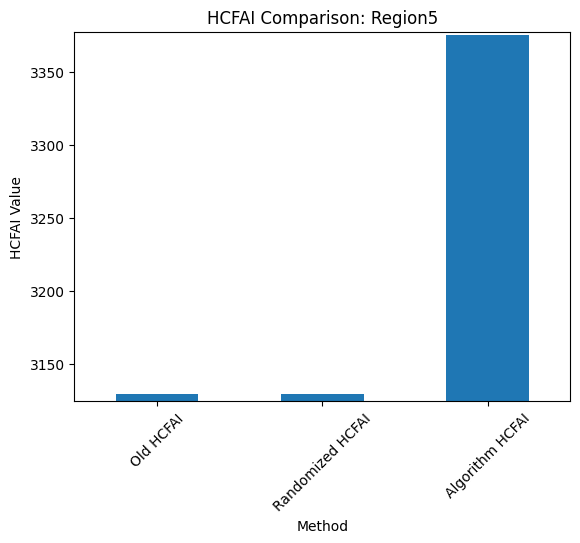

In [ ]:
hcfai_compare_df =  pd.DataFrame(
    {' ': ['SUM'],
    'Old HCFAI': og_HCFAI,
     'Randomized HCFAI': highest_rdm_HCFAI,
     'Algorithm HCFAI': updated_HCFAI
    })

import matplotlib.pyplot as plt
# Preparing the data for plotting
# Since we have only one row with label 'SUM', we'll use it as index
hcfai_compare_df.set_index(' ', inplace=True)
hcfai_compare_df = hcfai_compare_df.transpose()  # Transpose for easier plotting

# Plotting the bar chart
hcfai_compare_df.plot(kind='bar', legend=False)
plt.title(f'HCFAI Comparison: Region{region-1}')
plt.ylabel('HCFAI Value')
plt.ylim(min([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])-5, max([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])+2)
plt.xlabel('Method')
plt.xticks(rotation=45)
plt.show()

# Validation - PCF from PHFDP

Index(['flood_probability_value', 'rain intensity_value', 'drought_value',
       'Distance_to_Nearest_RHU_km', 'popden_chi', 'popden_eld', 'popden_all',
       'popden_wom', 'popden_w_1', 'popden_you', 'HCFAI', 'total_population',
       'RHU_Presence', 'ID', 'buildability_landcov', 'Road_Presence',
       'POI_Presence', 'Nearest_RHU', 'Cluster'],
      dtype='object')
2948.0333502321128
181.51564885076996
2942.444349649627
187.10464943325582
2941.884754367491
187.66424471539136
2945.6573287801984
183.89167030268385
2947.173344599789
182.3756544830939
2947.817274170791
181.73172491209152
2938.894488396788
190.65451068609403
2944.044411362487
185.5045877203948
2944.8712836695413
184.67771541334122
2943.9921839980166
185.55681508486583
=========== OG HCFAI RESULTS ===========
ORIGINAL HCFAI 3129.548999082882
=========== RANDOM HCFAI RESULTS ===========
RANDOMIZED HCFAI [10-fold]:  3129.548999082883
=========== OPTIMIZED HCFAI RESULTS ===========
OPTIMIZED HCFAI  3219.7405251802743


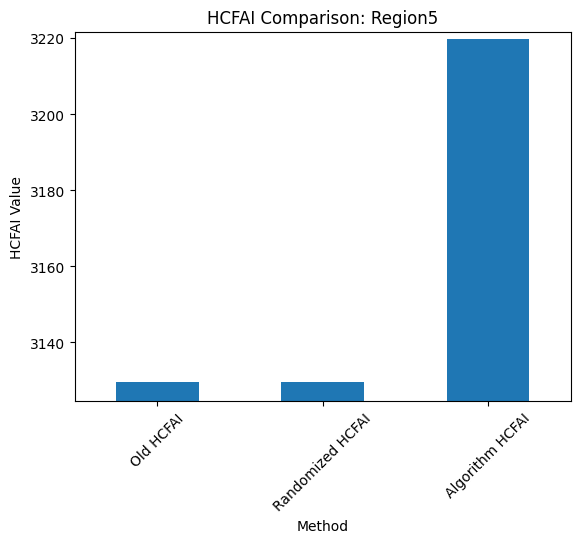

In [ ]:
import random
import pandas as pd

def getRandom48(candidate_sites, random_seed=None):
    """
    Randomly select 48 sites from the candidate sites DataFrame.

    Parameters:
        candidate_sites (DataFrame): DataFrame containing information about all candidate sites.
        random_seed (int): Random seed for reproducibility.

    Returns:
        DataFrame: Randomly selected 48 sites DataFrame.
    """
    if random_seed is not None:
        random.seed(random_seed)
    candidate_sites_shuffled = candidate_sites.sample(frac=1).reset_index(drop=True)
    random_48 = candidate_sites_shuffled.sample(n=PCF)
    return random_48


def randomize(region_df, candidate_sites, random_seed):
    """
    Randomize the selection of 48 sites and update the overall HCFAI value.
    Parameters:
        region_df (DataFrame): DataFrame containing information about all sites in the region.
    Returns:
        tuple: Tuple containing the updated overall HCFAI value and the IDs of randomly selected sites.
    """
    HCFAI_overall_before = overallHCFAI(region_df)
    # print("Overall HCFAI (before randomization): ", HCFAI_overall_before)
    random_48 = getRandom48(candidate_sites, random_seed)
    columns_to_merge = ['ID', 'total_population',
                        'popden_chi', 'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1',
                        'popden_all', 'flood_probability_value', 'rain intensity_value',
                        'drought_value', 'buildability_landcov', 'RHU_Presence',
                        'Road_Presence', 'POI_Presence', 'Nearest_RHU',
                        'Distance_to_Nearest_RHU_km', 'HCFAI']
    merged_sites = random_48.merge(region_df[columns_to_merge], on='ID', how='left')
    missing_cols = [col for col in region_df.columns if col != ['ID']]
    for col in missing_cols:
        if 'ID' not in region_df.columns:
            region_df.set_index('ID', inplace=True)
        merged_sites[col] = merged_sites[col].fillna(region_df[col])
    # Calculate HCFAI for the remaining sites in region_df
    remaining_sites = region_df[~region_df['ID'].isin(merged_sites['ID'])]
    remaining_HCFAI = overallHCFAI(remaining_sites)
    print(remaining_HCFAI)
    selected_sites_HCFAI = overallHCFAI(merged_sites)
    print(selected_sites_HCFAI)

    # Calculate updated overall HCFAI
    updated_HCFAI = remaining_HCFAI + selected_sites_HCFAI
    # print(f"Updated HCFAI: ", updated_HCFAI)
    return updated_HCFAI, random_48['ID'].tolist()

print(raw_rg1_clustered.columns)
# raw_rg1_clustered = raw_rg1_clustered.drop('total_population',axis=1, inplace=True)

# Example usage
rdm_hcfai = []
rdm_points = []
for i in range(10):
    random_seed = i  # Use a different random seed for each iteration
    rdm_ovHCFAI, rdm_48 = randomize(raw_rg1_clustered, candidate_sites, random_seed)
    rdm_hcfai.append(rdm_ovHCFAI)
    rdm_points.append(rdm_48)

rdm_HCFAI_avg = sum(rdm_hcfai) / len(rdm_hcfai)
highest_rdm_HCFAI = max(rdm_hcfai)
# print("Average HCFAI after randomization: ", rdm_HCFAI_avg)

Results_rdmsum = pd.DataFrame({
    'Hex IDs': rdm_points,
    'HCFAI': rdm_hcfai
})

print("=========== OG HCFAI RESULTS ===========")
print("ORIGINAL HCFAI", og_HCFAI)
print("=========== RANDOM HCFAI RESULTS ===========")
# print("RANDOMIZED HCFAI [All, 10-fold]", rdm_hcfai)
print("RANDOMIZED HCFAI [10-fold]: ", highest_rdm_HCFAI)
# print("RANDOMIZED HCFAI AVG[10 fold]: ", rdm_HCFAI_avg)
print("=========== OPTIMIZED HCFAI RESULTS ===========")
print("OPTIMIZED HCFAI ", updated_HCFAI)

hcfai_compare_df =  pd.DataFrame(
    {' ': ['SUM'],
    'Old HCFAI': og_HCFAI,
     'Randomized HCFAI': highest_rdm_HCFAI,
     'Algorithm HCFAI': updated_HCFAI
    })

import matplotlib.pyplot as plt
# Preparing the data for plotting
# Since we have only one row with label 'SUM', we'll use it as index
hcfai_compare_df.set_index(' ', inplace=True)
hcfai_compare_df = hcfai_compare_df.transpose()  # Transpose for easier plotting

# Plotting the bar chart
hcfai_compare_df.plot(kind='bar', legend=False)
plt.title(f'HCFAI Comparison: Region{region-1}')
plt.ylabel('HCFAI Value')
plt.ylim(min([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])-5, max([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])+2)
plt.xlabel('Method')
plt.xticks(rotation=45)
plt.show()